In [4]:
%load_ext autoreload
%autoreload 2

from computage.deage.kdm import KlemeraDoubalEstimator
from computage.deage.pls import PLS1
from computage.utils.data_utils import test_dataset
from computage.utils.metric_utils import print_metrics
import pickle
from biolearn.model_gallery import ModelGallery

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
gallery = ModelGallery()
list(gallery.model_definitions.keys())
k1 = 'HRSInCHPhenoAge'
k2 = 'PhenoAge'

indices = gallery.get(k1).clock.coefficients.index

In [78]:
# data, meta = pd.read_pickle('/tank/projects/computage/train/GSE40279.pkl.gz', compression='gzip').values()
data, meta = pd.read_pickle('/tank/projects/computage/train/GSE132203.pkl.gz', compression='gzip').values()

<Axes: >

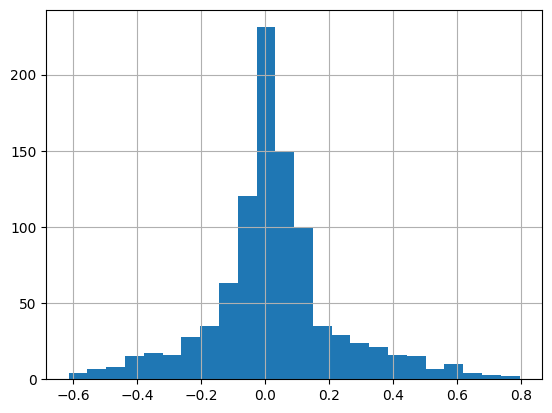

In [79]:
corrcoef = data[indices].corrwith(meta['age'])
corrcoef.hist(bins=24)

In [80]:
topsites = corrcoef.abs().sort_values(ascending=False)[:50].index
y = meta['age']

In [81]:
def _fit_feature(y, x):
    from sklearn.metrics import r2_score
    from scipy.stats import linregress
    idx = np.isfinite(x) #y should always be finite
    y = y[idx] 
    x = x[idx]
    s, i, r, p, serr = linregress(y, x)
    x_cap = y * s + i
    r2 = r2_score(x, x_cap)
    rss = (np.square(x_cap - x)).sum()
    rse = np.sqrt(rss / (x.shape[0] - 2))
    #secondary analysis
    residuals = np.abs(x - x_cap)
    s_res, i_res, r_res, p_res, _ = linregress(y, residuals)
    return s, i, r, p, serr, rse, r2, s_res, i_res, r_res, p_res

stats = data[topsites].apply(lambda x: _fit_feature(y, x), result_type='expand').reset_index(drop=True).rename(index={
                                                                                        0: 'slope', 
                                                                                        1: 'intercept', 
                                                                                        2: 'rvalue', 
                                                                                        3: 'p-value', 
                                                                                        4: 'stderr', 
                                                                                        5: 'rse',
                                                                                        6: 'r2',
                                                                                        7: 's_res',
                                                                                        8: 'i_res',
                                                                                        9: 'r_res',
                                                                                        10: 'p_res'
                                                                                        }).T

In [85]:
#stats['fi'] = np.abs(stats['rvalue'])**2 / stats['rse']**2 * stats['r_res']**2
stats['fi'] = np.abs(stats['rvalue'])**2 * stats['r_res']**2

stats.sort_values('fi', ascending=False).head(7)

,slope,intercept,rvalue,p-value,stderr,rse,r2,s_res,i_res,r_res,p_res,fi
cg08097417,0.001528,0.020101,0.672365,1.064149e-105,0.000060,0.020717,0.452074,0.000371,-0.000053,0.336522,1.677767e-22,0.051196
cg21159778,0.002342,-0.018194,0.590940,6.343680e-76,0.000114,0.039348,0.349210,0.000664,0.001851,0.321558,1.478235e-20,0.036108
cg03032497,0.002732,0.041485,0.683129,2.358063e-110,0.000104,0.035984,0.466665,0.000404,0.008331,0.195639,2.677013e-08,0.017862
cg07955995,0.000847,0.005130,0.512719,4.154313e-54,0.000051,0.017457,0.262881,0.000235,0.003239,0.254016,4.391717e-13,0.016962
cg17243289,0.001418,0.049064,0.490645,2.168934e-49,0.000089,0.031031,0.240732,0.000391,0.006719,0.235035,1.935725e-11,0.013298
cg14911690,0.000661,-0.005704,0.469002,1.006285e-44,0.000044,0.015338,0.219963,0.000233,-0.000039,0.244259,2.904816e-12,0.013124
cg16832267,0.001416,0.008516,0.475860,3.632364e-46,0.000093,0.032237,0.226442,0.000447,0.003572,0.238596,9.395271e-12,0.012891


In [86]:
stats.loc['cg08097417']

slope         1.527508e-03
intercept     2.010069e-02
rvalue        6.723648e-01
p-value      1.064149e-105
stderr        5.971766e-05
rse           2.071652e-02
r2            4.520744e-01
s_res         3.707089e-04
i_res        -5.263701e-05
r_res         3.365219e-01
p_res         1.677767e-22
fi            5.119608e-02
Name: cg08097417, dtype: float64

(-0.35, 0.35)

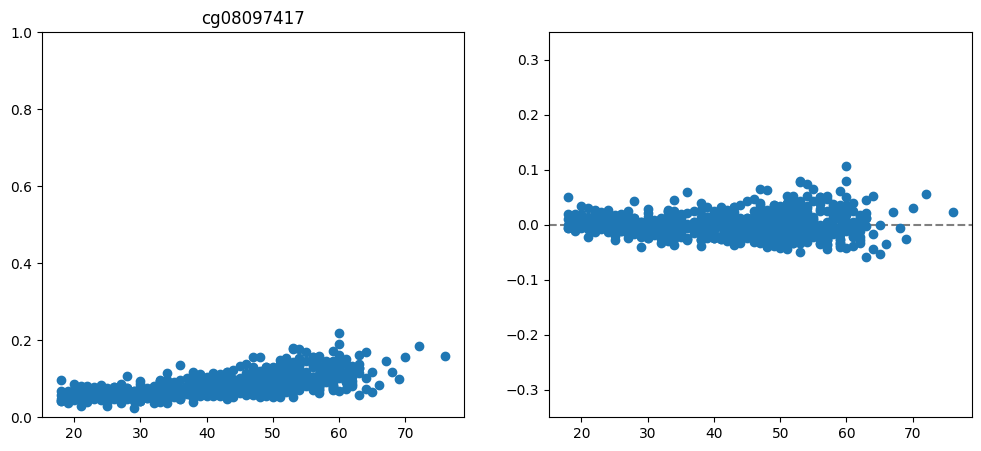

In [87]:
site = 'cg08097417'

fig, axes = plt.subplots(1, 2, figsize=(12,5))
resid = data[site] - stats.loc[site, 'slope'] * y - stats.loc[site, 'intercept']

axes[0].scatter(y, data[site])
axes[0].set_ylim([0, 1])
axes[0].set_title(site)
axes[1].axhline(0, color='grey', ls='--', zorder=0)
axes[1].scatter(y, resid)
axes[1].set_ylim([-0.35, 0.35])


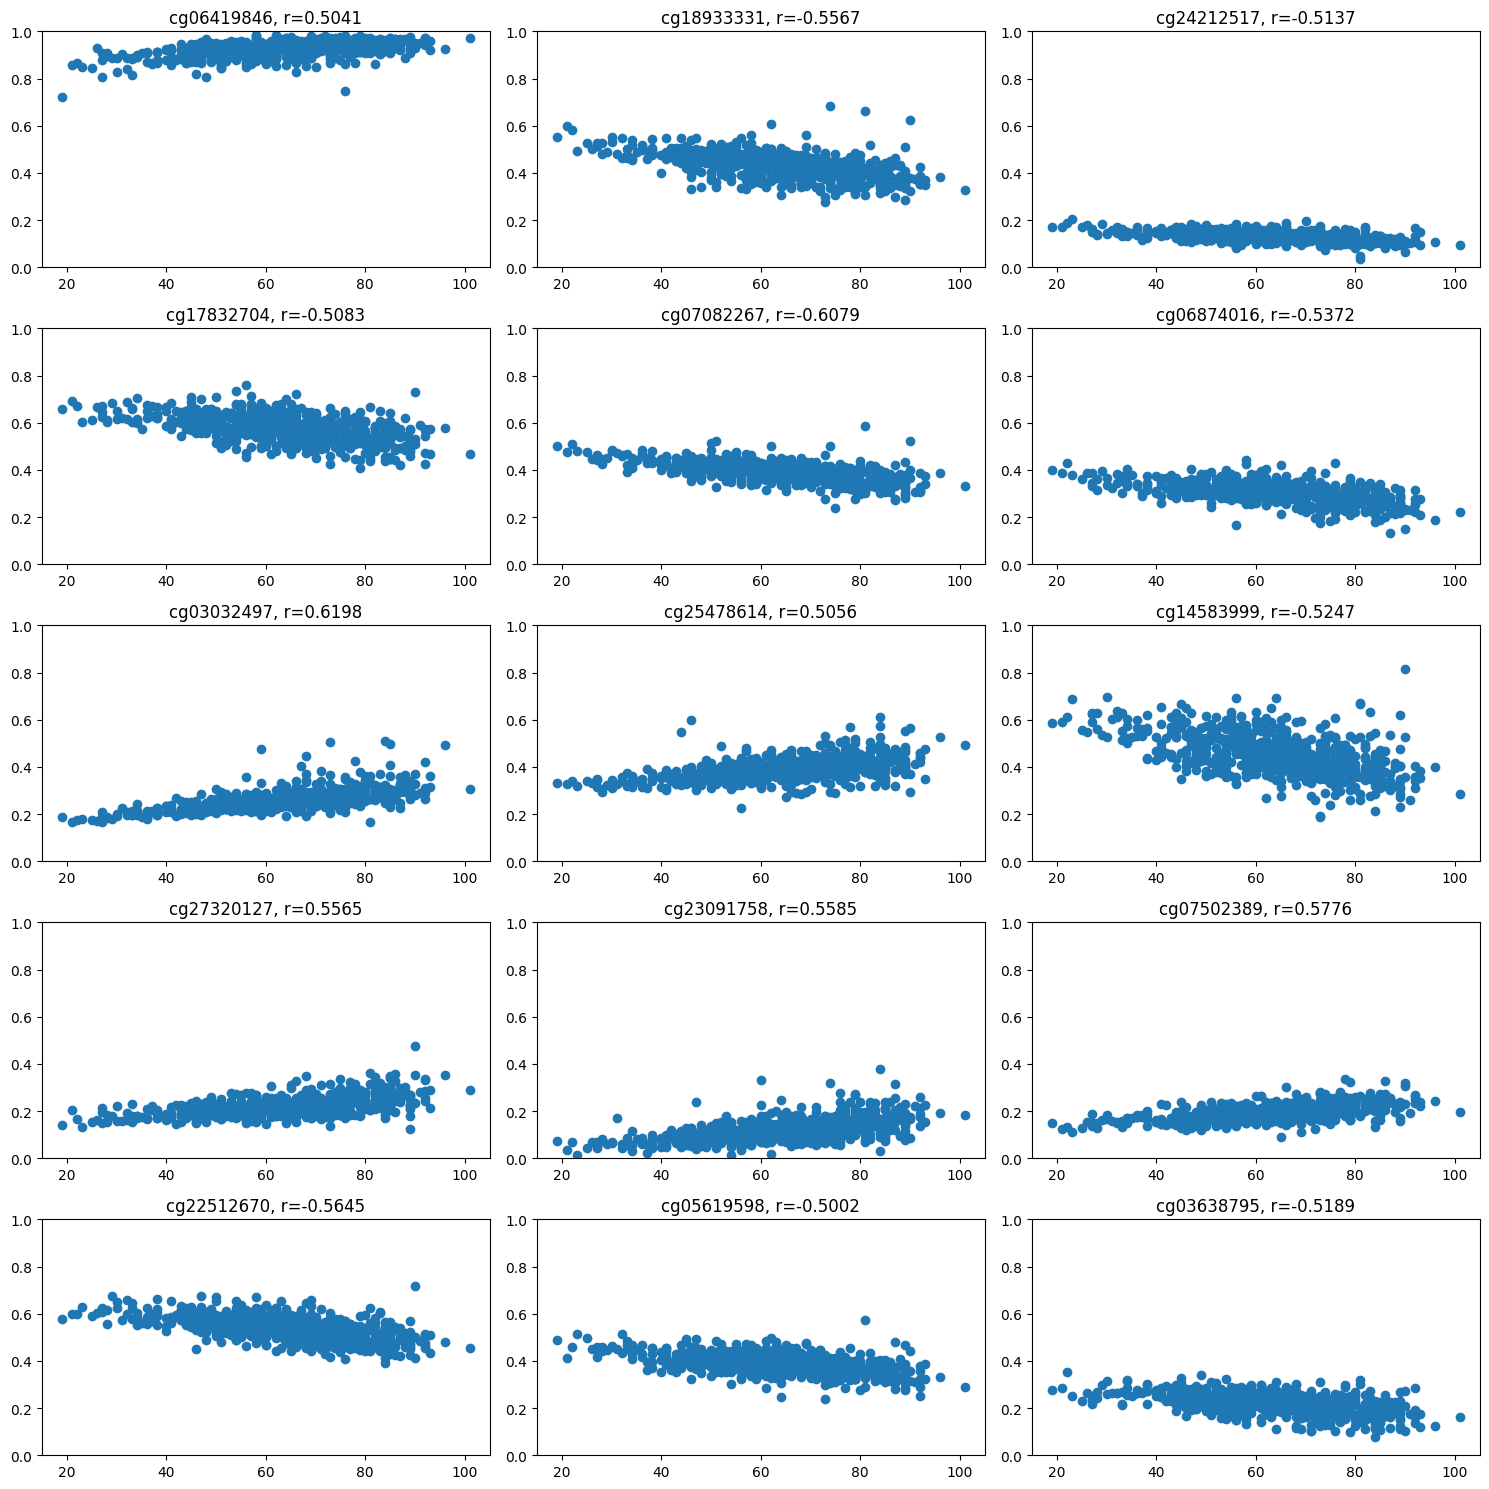

In [72]:
nsamples = 15

choice = np.random.choice(topsites, nsamples, replace=False)

fig, axs = plt.subplots(5, 3, figsize=(15, 15))
# Iterate over the columns and create a boxplot for each one
for i, col in enumerate(choice):
    ax = axs[i // 3, i % 3]
    ax.scatter(meta['age'], data[col])
    ax.set_ylim([0, 1])
    r = np.corrcoef(meta['age'], data[col])[0,1]
    ax.set_title(f'{col}, r={round(r, 4)}')
    # Adjust the layout and show the plot
plt.tight_layout()
plt.show()
